In [78]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [79]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [80]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [81]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [82]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [83]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [84]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [85]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [86]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [87]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
results = calc_temps('2016-08-23', '2017-08-23')
results

[(58.0, 74.59058295964125, 87.0)]

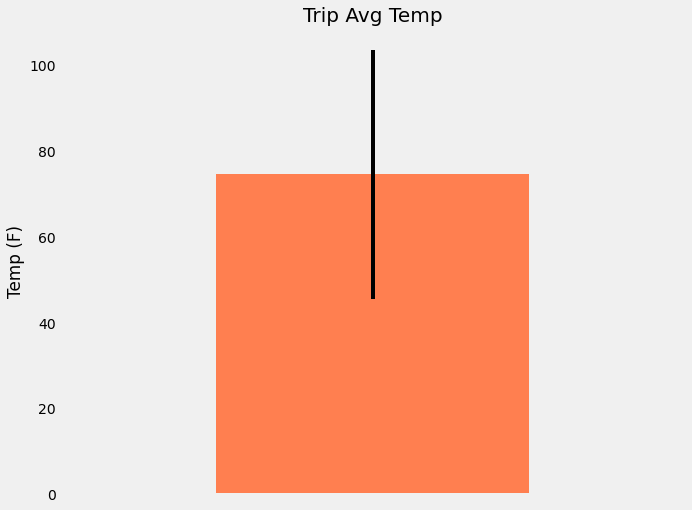

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(results, columns=['Min-Temp', 'Avg-Temp', 'Max-Temp'])
avg_temp = df['Avg-Temp']
minmax_temp = df.iloc[0]['Max-Temp'] - df.iloc[0]['Min-Temp']
avg_temp.plot(kind='bar', yerr=minmax_temp, figsize=(10,8), color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

### Daily Rainfall Average

In [89]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
build_query = [Station.name, 
                 Station.station, 
                 Station.elevation, 
                 Station.longitude, 
                 Station.latitude, 
                 func.sum(Measurement.prcp).label('Total Rainfall')]

query_results = session.query(*build_query).\
                  filter(Measurement.station == Station.station).\
                  filter(Measurement.date >= '2016-08-23').\
                  filter(Measurement.date <= '2017-08-23').\
                  group_by(Station.name).\
                  order_by(func.sum(Measurement.prcp).desc()).\
                  all()

df = pd.DataFrame(np.array(query_results),columns=['Name', 'Station', 'Elev', 'Long', 'Lat', 'Total_Rainfall'])
df

,Name,Station,Elev,Long,Lat,Total_Rainfall
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,152.4,-157.8025,21.3331,147.81000000000006
1,"WAIHEE 837.5, HI US",USC00519281,32.9,-157.84888999999998,21.45167,70.03000000000003
2,"KANEOHE 838.1, HI US",USC00513117,14.6,-157.8015,21.4234,48.510000000000026
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,19.5,-157.71139,21.33556,38.01
4,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,7.0,-157.8374,21.5213,33.239999999999995
5,"WAIKIKI 717.2, HI US",USC00519397,3.0,-157.8168,21.2716,16.089999999999986
6,"PEARL CITY, HI US",USC00517948,11.9,-157.9751,21.3934,4.59


In [90]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [91]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

last_day = dt.date(2017, 8, 7)
first_day = dt.date(2017, 8, 1)

# Use the start and end date to create a range of dates
date_ranges = []
date = first_day
while date <= last_day:
        date_ranges.append(date)
        date+=dt.timedelta(days=1)

# Strip off the year and save a list of strings in the format %m-%d
i=0
while i < len(date_ranges):
    date_ranges[i] = date_ranges[i].strftime('%m-%d')
    i+=1


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals_min = []
normals_avg = []
normals_max = []

for date in date_ranges:
       normals_min.append(daily_normals(date)[0][0])
       normals_avg.append(round(daily_normals(date)[0][1], 0))
       normals_max.append(daily_normals(date)[0][2])


In [92]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame({'Date': date_ranges,
                          'Min':normals_min, 
                           'Max': normals_max, 
                           'Average': normals_avg})
normals_df.set_index('Date', inplace=True)
normals_df

,Min,Max,Average
Date,,,
08-01,67.0,83.0,76.0
08-02,68.0,84.0,76.0
08-03,70.0,85.0,77.0
08-04,69.0,84.0,77.0
08-05,69.0,82.0,76.0
08-06,67.0,83.0,76.0
08-07,71.0,83.0,77.0


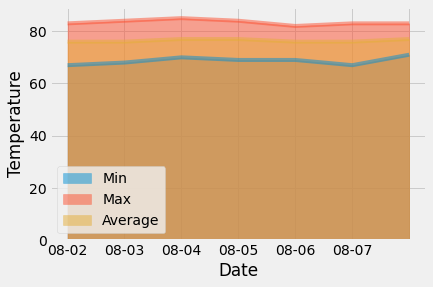

In [93]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot(kind='area', stacked=False)
ax.set_xticklabels(normals_df.index)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.show()

## Close Session

In [94]:
session.close()